In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import openslide
from openslide import OpenSlideError
from openslide.deepzoom import DeepZoomGenerator
import pandas as pd
import PIL
from PIL import Image
import scipy.ndimage as ndi
from scipy.ndimage.morphology import binary_fill_holes
import skimage.morphology
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.morphology import binary_closing, binary_dilation, disk, binary_erosion
from skimage.filters import threshold_minimum, threshold_otsu, threshold_yen

In [2]:
!ls data

breast_cancer	      mitoses_test_image_data	training_ground_truth.csv
experiments	      mitoses_train_image_data	training_image_data
images		      OLD
mitoses_ground_truth  testing_image_data


In [3]:
!ls data/training_image_data

TUPAC-TR-001.svs  TUPAC-TR-126.svs  TUPAC-TR-251.svs  TUPAC-TR-376.svs
TUPAC-TR-002.svs  TUPAC-TR-127.svs  TUPAC-TR-252.svs  TUPAC-TR-377.svs
TUPAC-TR-003.svs  TUPAC-TR-128.svs  TUPAC-TR-253.svs  TUPAC-TR-378.svs
TUPAC-TR-004.svs  TUPAC-TR-129.svs  TUPAC-TR-254.svs  TUPAC-TR-379.svs
TUPAC-TR-005.svs  TUPAC-TR-130.svs  TUPAC-TR-255.svs  TUPAC-TR-380.svs
TUPAC-TR-006.svs  TUPAC-TR-131.svs  TUPAC-TR-256.svs  TUPAC-TR-381.svs
TUPAC-TR-007.svs  TUPAC-TR-132.svs  TUPAC-TR-257.svs  TUPAC-TR-382.svs
TUPAC-TR-008.svs  TUPAC-TR-133.svs  TUPAC-TR-258.svs  TUPAC-TR-383.svs
TUPAC-TR-009.svs  TUPAC-TR-134.svs  TUPAC-TR-259.svs  TUPAC-TR-384.svs
TUPAC-TR-010.svs  TUPAC-TR-135.svs  TUPAC-TR-260.svs  TUPAC-TR-385.svs
TUPAC-TR-011.svs  TUPAC-TR-136.svs  TUPAC-TR-261.svs  TUPAC-TR-386.svs
TUPAC-TR-012.svs  TUPAC-TR-137.svs  TUPAC-TR-262.svs  TUPAC-TR-387.svs
TUPAC-TR-013.svs  TUPAC-TR-138.svs  TUPAC-TR-263.svs  TUPAC-TR-388.svs
TUPAC-TR-014.svs  TUPAC-TR-139.svs  TUPAC-TR-264.svs  TUPAC-TR-389.svs
TUPAC-

In [4]:
root = "data"
path = os.path.join(root, "training_image_data")
root, path

('data', 'data/training_image_data')

In [5]:
# get files
files = sorted(glob.glob(os.path.join(path, "*.svs")))
files

['data/training_image_data/TUPAC-TR-001.svs',
 'data/training_image_data/TUPAC-TR-002.svs',
 'data/training_image_data/TUPAC-TR-003.svs',
 'data/training_image_data/TUPAC-TR-004.svs',
 'data/training_image_data/TUPAC-TR-005.svs',
 'data/training_image_data/TUPAC-TR-006.svs',
 'data/training_image_data/TUPAC-TR-007.svs',
 'data/training_image_data/TUPAC-TR-008.svs',
 'data/training_image_data/TUPAC-TR-009.svs',
 'data/training_image_data/TUPAC-TR-010.svs',
 'data/training_image_data/TUPAC-TR-011.svs',
 'data/training_image_data/TUPAC-TR-012.svs',
 'data/training_image_data/TUPAC-TR-013.svs',
 'data/training_image_data/TUPAC-TR-014.svs',
 'data/training_image_data/TUPAC-TR-015.svs',
 'data/training_image_data/TUPAC-TR-016.svs',
 'data/training_image_data/TUPAC-TR-017.svs',
 'data/training_image_data/TUPAC-TR-018.svs',
 'data/training_image_data/TUPAC-TR-019.svs',
 'data/training_image_data/TUPAC-TR-020.svs',
 'data/training_image_data/TUPAC-TR-021.svs',
 'data/training_image_data/TUPAC-T

In [6]:
# extract slide number with pattern "...###.svs"
num_to_file = {int(file[-7:-4]):file for file in files}
num_to_file

{1: 'data/training_image_data/TUPAC-TR-001.svs',
 2: 'data/training_image_data/TUPAC-TR-002.svs',
 3: 'data/training_image_data/TUPAC-TR-003.svs',
 4: 'data/training_image_data/TUPAC-TR-004.svs',
 5: 'data/training_image_data/TUPAC-TR-005.svs',
 6: 'data/training_image_data/TUPAC-TR-006.svs',
 7: 'data/training_image_data/TUPAC-TR-007.svs',
 8: 'data/training_image_data/TUPAC-TR-008.svs',
 9: 'data/training_image_data/TUPAC-TR-009.svs',
 10: 'data/training_image_data/TUPAC-TR-010.svs',
 11: 'data/training_image_data/TUPAC-TR-011.svs',
 12: 'data/training_image_data/TUPAC-TR-012.svs',
 13: 'data/training_image_data/TUPAC-TR-013.svs',
 14: 'data/training_image_data/TUPAC-TR-014.svs',
 15: 'data/training_image_data/TUPAC-TR-015.svs',
 16: 'data/training_image_data/TUPAC-TR-016.svs',
 17: 'data/training_image_data/TUPAC-TR-017.svs',
 18: 'data/training_image_data/TUPAC-TR-018.svs',
 19: 'data/training_image_data/TUPAC-TR-019.svs',
 20: 'data/training_image_data/TUPAC-TR-020.svs',
 21: 'dat

In [7]:
# get labels
filepath = os.path.join(root, "training_ground_truth.csv")
labels_df = pd.read_csv(filepath, names=["tumor_score", "molecular_score"], header=None)
labels_df["slide_num"] = labels_df.index + 1  # slide numbering starts at 1
labels_df.set_index("slide_num", drop=False, inplace=True)  # use the slide num as index
labels_df["path"] = labels_df["slide_num"].map(num_to_file)  # add filenames
labels_df = labels_df.dropna()  # remove rows for slides that aren't available
labels_df

,tumor_score,molecular_score,slide_num,path
slide_num,,,,
1,1,-0.857943,1,data/training_image_data/TUPAC-TR-001.svs
2,2,0.525464,2,data/training_image_data/TUPAC-TR-002.svs
3,2,-0.769384,3,data/training_image_data/TUPAC-TR-003.svs
4,2,-0.166413,4,data/training_image_data/TUPAC-TR-004.svs
5,2,0.423333,5,data/training_image_data/TUPAC-TR-005.svs
6,1,-0.260405,6,data/training_image_data/TUPAC-TR-006.svs
7,3,0.290372,7,data/training_image_data/TUPAC-TR-007.svs
8,1,-0.839100,8,data/training_image_data/TUPAC-TR-008.svs
9,1,0.224461,9,data/training_image_data/TUPAC-TR-009.svs


In [8]:
# map label to files
label_to_files = {int(label):list(group["path"]) for label,group in labels_df.groupby("tumor_score")}
label_to_files

{1: ['data/training_image_data/TUPAC-TR-001.svs',
  'data/training_image_data/TUPAC-TR-006.svs',
  'data/training_image_data/TUPAC-TR-008.svs',
  'data/training_image_data/TUPAC-TR-009.svs',
  'data/training_image_data/TUPAC-TR-010.svs',
  'data/training_image_data/TUPAC-TR-014.svs',
  'data/training_image_data/TUPAC-TR-015.svs',
  'data/training_image_data/TUPAC-TR-016.svs',
  'data/training_image_data/TUPAC-TR-017.svs',
  'data/training_image_data/TUPAC-TR-018.svs',
  'data/training_image_data/TUPAC-TR-020.svs',
  'data/training_image_data/TUPAC-TR-022.svs',
  'data/training_image_data/TUPAC-TR-025.svs',
  'data/training_image_data/TUPAC-TR-028.svs',
  'data/training_image_data/TUPAC-TR-031.svs',
  'data/training_image_data/TUPAC-TR-035.svs',
  'data/training_image_data/TUPAC-TR-037.svs',
  'data/training_image_data/TUPAC-TR-042.svs',
  'data/training_image_data/TUPAC-TR-044.svs',
  'data/training_image_data/TUPAC-TR-049.svs',
  'data/training_image_data/TUPAC-TR-050.svs',
  'data/tr

In [9]:
def compute_downsample_scale(slide, mag):
  """
  Determine the level of downsampling that will
  be needed for an image sampled at the highest
  resolution to return an image at the desired
  magnification.
  
  Args:
    slide: An OpenSlide slide.
    mag: Desired magnification level.

  Returns:
    The downsampling scale.
  """
  try:
    mag_slide = int(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
    scale = mag_slide / mag
  except ValueError:
    # In case the slide magnification level is unknown, just
    # assume the highest resolution is the desired magnification.
    scale = 1.0
  return scale

In [10]:
# Filter Tile For Dimensions & Tissue Threshold
def optical_density(tile):
  """
  Convert a tile to optical density values.

  Args:
    tile: A 3D NumPy array of shape (h, w, c) representing
      an RGB image.

  Returns:
    A 3D NumPy array of shape (h, w, c)
    representing optical density values.
  """
  tile = tile.astype(np.float64)
  #od = -np.log10(tile/255 + 1e-8)
  od = -np.log((tile+1)/240)
  return od


def keep_tile(tile, h, w, tissue_threshold):
  """
  Determine if a tile should be kept.

  This filters out tiles based on size and a tissue percentage
  threshold, using a custom algorithm. If a tile has height &
  width equal to (h, w), and contains greater than or equal to
  the given percentage, then it will be kept; otherwise it will
  be filtered out.

  Args:
    tile: An RGB PIL Image of size (w, h).
    h: Desired tile height.
    w: Desired tile width.
    tissue_threshold: Tissue percentage lower bound.

  Returns:
    A Boolean indicating whether or not a tile should be kept for
    future usage.
  """
  if tile.size != (w, h):
    print("size failed!")
    keep = False
  else:
    tile = np.asarray(tile)  # RGB PIL (w, h) -> (h, w, 3)
    tile_orig = tile

    # Check 1
    # Convert 3D RGB image to 2D grayscale image, from
    # 0 (dense tissue) to 1 (plain background).
    tile = rgb2gray(tile)
    # 8-bit depth complement, from 1 (dense tissue)
    # to 0 (plain background).
    tile = 1 - tile
    # Canny edge detection with hysteresis thresholding.
    # This returns a binary map of edges, with 1 equal to
    # an edge. The idea is that tissue would be full of
    # edges, while background would not.
    tile = canny(tile)
    # Binary closing, which is a dilation followed by
    # an erosion. This removes small dark spots, which
    # helps remove noise in the background.
    tile = binary_closing(tile, disk(10))
    # Binary dilation, which enlarges bright areas,
    # and shrinks dark areas. This helps fill in holes
    # within regions of tissue.
    tile = binary_dilation(tile, disk(10))
    # Fill remaining holes within regions of tissue.
    tile = binary_fill_holes(tile)
    # Calculate percentage of tissue coverage.
    percentage = tile.mean()
    check1 = percentage >= tissue_threshold

    # Check 2
    tile = tile_orig
    # Convert to optical density values
    tile = optical_density(tile)
    # Threshold at beta
    beta = 0.15
    tile = np.min(tile, axis=2) >= beta
    # Apply morphology for same reasons as above.
    tile = binary_closing(tile, disk(2))
    tile = binary_dilation(tile, disk(2))
    tile = binary_fill_holes(tile)
    percentage = tile.mean()
    check2 = percentage >= tissue_threshold

    keep = check1 and check2
  return keep

In [11]:
def uniform_tile_sampler(label_to_files, h, w, mag, tissue_threshold):
  """
  Generate acceptable tiles sampled uniformly from (1) the
  number of labels, (2) the group of slides associated with
  that label, and (3) from within that slide, filtering out
  unwanted tiles from (3) until a desirable one is found.

  The goal here is to avoid introducing biases into a
  downstream model due to overexposure to certain slides,
  since some slides may contain more desirable tiles than
  other ones.

  Args:
    label_to_files: A dictionary mapping class labels to
      lists of filenames.
    h: Tile height to generate.
    w: Tile width to generate.
    mag: Magnification level to extract tiles from.
    tissue_threshold: Tissue percentage lower bound for
      filtering.

  Yields:
    Yields a (label, tile, metadata) tuple, where `label`
    is an integer class label, `tile` is a PIL RGB Image
    of size (w, h), and `metadata` is a
    (filename, x, y, scale) tuple, where `filename`
    is the name of the slide file, `x` & `y` are pixel
    coordinates of the top left corner of the tile extracted
    from the highest magnification level in the slide, `scale`
    is a float value equal to the highest magnification level
    divided by the desired one.  The returned tile was
    extracted from the highest magnification level at size
    (w*scale, h*scale) and resized to (w, h) to yield a tile
    that was effectively extracted from the desired
    magnification level.  If the PIL Image is converted to
    a NumPy array with `np.asarray(tile)`, the shape will be
    (h, w, 3) -- note that the height and width switch axes
    from a PIL Image to a NumPy array, but the desired result
    is the same.
  """
  labels = list(label_to_files.keys())

  while True:  # generate tiles forever
    # sample a label
    label = random.choice(labels)

    # sample a slide
    # TODO: wrap in a try/catch for broken slides
    filename = random.choice(label_to_files[label])
    slide = openslide.open_slide(filename)
    
    # slide info
    width, height = slide.dimensions
    scale = compute_downsample_scale(slide, mag)
    w_scale, h_scale = int(w*scale), int(h*scale)  # scale at which to sample tile
    patches_w = (width - w_scale) // w_scale  # possible unique patches in x dimension
    patches_h = (height - h_scale) // h_scale  # possible unique patches in y dimension

    # sample a tile until a desirable one is found
    # TODO: add memoization to track tiles that have
    # already been sampled and failed filtering
    while True:
      x = np.random.randint(patches_w)  # sample a patch in the x dimension 
      y = np.random.randint(patches_h)  # sample a patch in the y dimension
      x = x * w_scale  # convert to pixel location in overall slide
      y = y * h_scale  # convert to pixel location in overall slide
      tile = slide.read_region((x, y), 0, (w_scale, h_scale))  # extract images at (w*scale, h*scale) size
      tile = tile.resize((w, h), PIL.Image.LANCZOS)  # downsample to (h, w)
      tile = tile.convert("RGB")  # RGBA -> RGB
      if keep_tile(tile, h, w, tissue_threshold):  # filter
        yield label, tile, (filename, x, y, scale)
        break

In [12]:
gen = uniform_tile_sampler(label_to_files, 224, 224, 20, 0.9)

In [13]:
# TODO: sample (x, y) from dimensions, filter tiles, combine into generator function to yield images

---

# Test new sampling policy

In [14]:
files_orig = files
files = files_orig[:100]

data/training_image_data/TUPAC-TR-004.svs
data/training_image_data/TUPAC-TR-337.svs
data/training_image_data/TUPAC-TR-349.svs
data/training_image_data/TUPAC-TR-435.svs
data/training_image_data/TUPAC-TR-436.svs
data/training_image_data/TUPAC-TR-009.svs
data/training_image_data/TUPAC-TR-001.svs
data/training_image_data/TUPAC-TR-021.svs
data/training_image_data/TUPAC-TR-052.svs
data/training_image_data/TUPAC-TR-089.svs


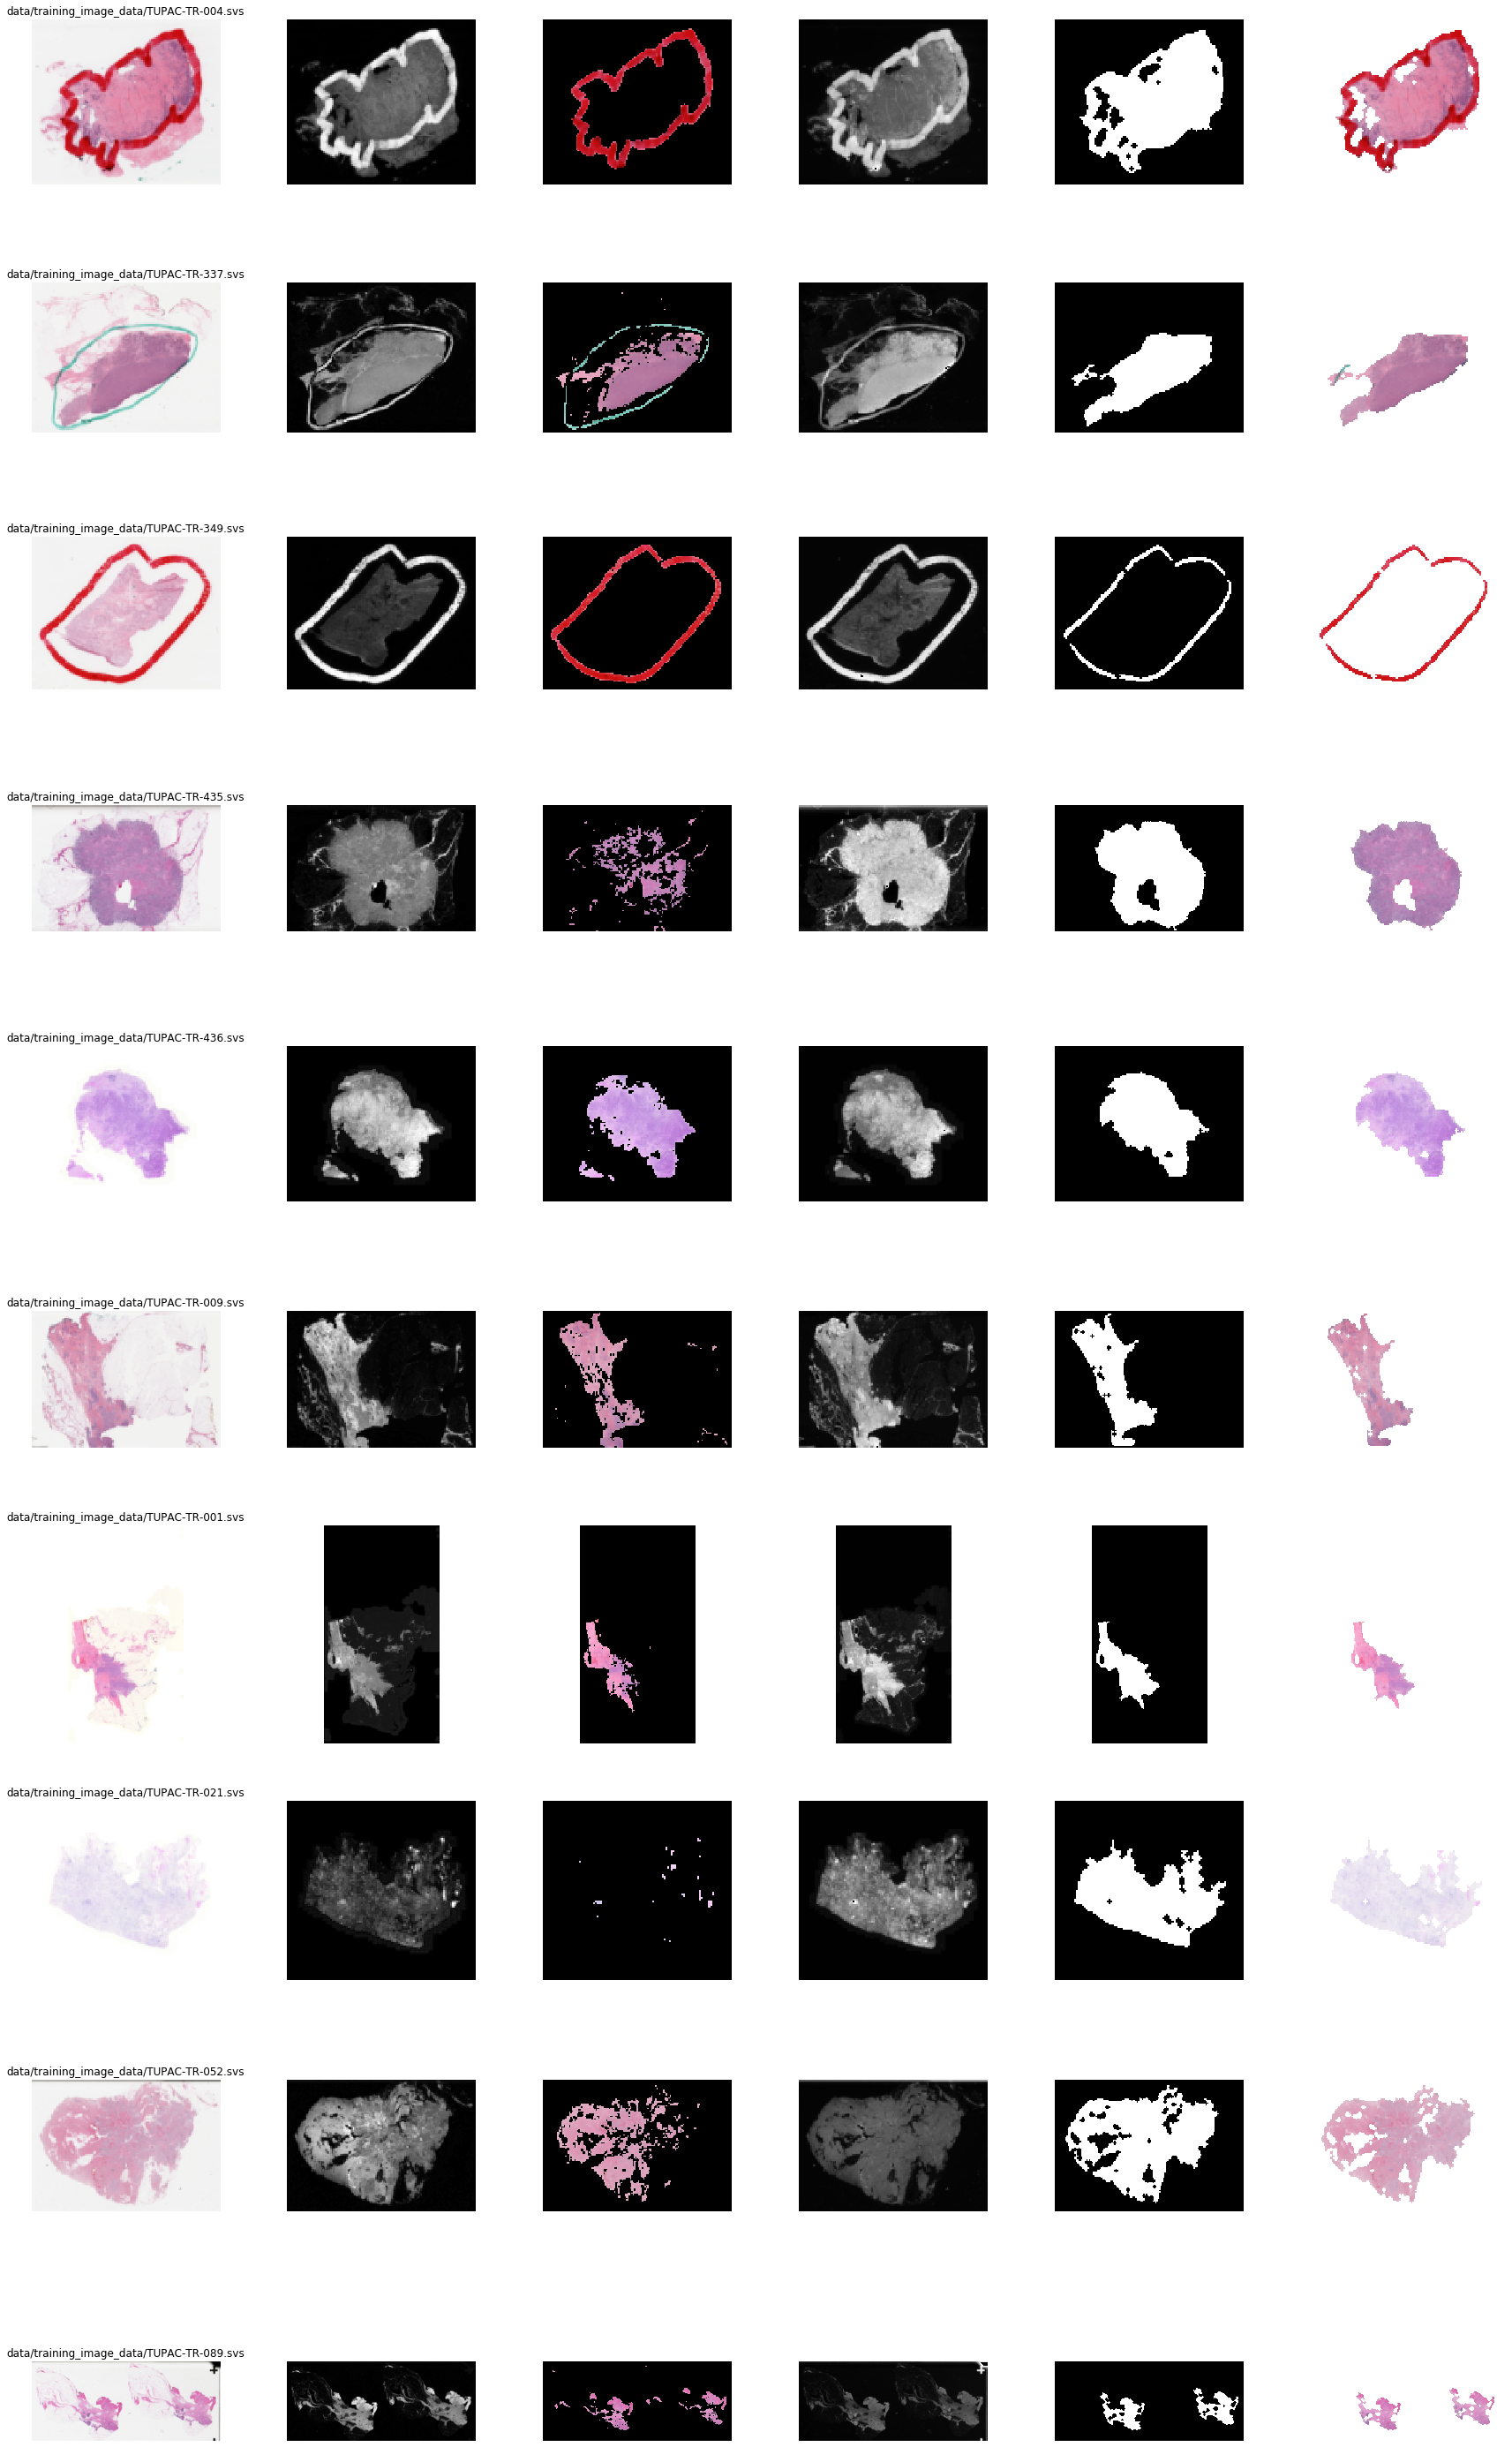

In [34]:
# import pdb; pdb.set_trace()
# new sampling policy (WIP)
w, h = 224, 224
mag = 20
# files = files_orig[:30]
# k = 30
# files = [files_orig[i] for i in random.sample(range(len(files_orig)), k)]
files = [num_to_file.get(i) for i in [4, 337, 349, 435, 436, 9, 1, 21, 52, 89]]
n = len(files)
nplots = 8
fig = plt.figure(figsize=(nplots*4, n*4))
for i, file in enumerate(files):
  # open WSI
  try:  # some slides are broken
    slide = openslide.open_slide(file)
  except OpenSlideError:
    continue
  print(file)
  wsi = slide.read_region((0,0), slide.level_count-1, slide.level_dimensions[-1])  # (x, y) == (col, row)
  
  # resize
  new_size = tuple(round(100*d/min(wsi.size)) for d in wsi.size)  # set shortest side to 100
  wsi_sm = wsi.resize(new_size, PIL.Image.BILINEAR)  # (w, h)
#   wsi_sm.convert("RGB").save("out/sampling_policy/wsi/{}.jpg".format(file[-7:-4]))
  wsi_sm_arr = np.asarray(wsi_sm)[...,:3]
  
  # use std dev normalized map to remove all white, all black, and generally all grayscale regions
  wsi_sm_arr_std = np.std(wsi_sm_arr, axis=2)
  wsi_sm_arr_std_map = wsi_sm_arr_std / wsi_sm_arr_std.max()
#   wsi_sm_arr_std_map = wsi_sm_arr_std < 1
  wsi_sm_arr_std_map = wsi_sm_arr_std_map < 0.5
#   thresh2 = threshold_otsu(wsi_sm_arr_std_map)
#   mask2 = wsi_sm_arr_std_map > thresh2
#   mask2 = skimage.morphology.remove_small_objects(mask2)
#   mask2 = skimage.morphology.binary_erosion(mask2)
#   mask2 = skimage.morphology.remove_small_objects(mask2)
  wsi_sm_arr = wsi_sm_arr * np.atleast_3d(~wsi_sm_arr_std_map)
  
  # look at rgb channels
  wsi_r, wsi_g, wsi_b = [np.squeeze(arr) for arr in np.dsplit(wsi_sm_arr, 3)]
  
  # 1. convert RGB image to grayscale image, from 0 (dense tissue) to 1 (plain background)
#   wsi_sm_gray = rgb2gray(np.asarray(wsi_sm))
  wsi_sm_gray = np.asarray(wsi_sm.convert('L'))
#   wsi_sm_gray = wsi_r
#   wsi_sm_gray = wsi_g

  # 2. apply automatic contrast enhancement
  wsi_sm_gray_enhance = skimage.exposure.rescale_intensity(wsi_sm_gray)
  
  # 3. compute 8-bit depth complement, from 1 (dense tissue) to 0 (plain background).
#   wsi_sm_gray_comp = 1 - wsi_sm_gray
#   wsi_sm_gray_comp_orig = wsi_sm_gray_comp
  wsi_sm_gray_enhance_comp = 1 - wsi_sm_gray_enhance
  wsi_sm_gray_comp = wsi_sm_gray_enhance_comp
  
  # segment and remove any markers (i.e., all red, all green, or all blue areas)
#   all_white = np.all(wsi_sm_arr > 240, 2)
#   all_black = np.all(wsi_sm_arr < 50, 2)
#   marker_red = (wsi_sm_arr[..., 0] > 200) & np.all(wsi_sm_arr[...,1:2] < 100, 2)
#   marker_green = (wsi_sm_arr[..., 1] > 200) & np.all(wsi_sm_arr[...,[0,2]] < 100, 2)
#   marker_green = (wsi_sm_arr[..., 1] > 200)
#   marker_blue = (wsi_sm_arr[..., 2] > 200) & np.all(wsi_sm_arr[...,0:1] < 100, 2)
  
  
#   wsi_sm_gray_comp = wsi_sm_gray_comp * ~all_grayscale
  
#   wsi_sm_gray_comp = wsi_sm_arr_std_map
  
#   wsi_sm_gray_comp = wsi_sm_gray_comp * ~all_white
#   wsi_sm_gray_comp = wsi_sm_gray_comp * ~all_black
#   wsi_sm_gray_comp = wsi_sm_gray_comp * ~marker_red
#   wsi_sm_arr_std_map = wsi_sm_arr_std_map * ~marker_red
#   wsi_sm_gray_comp = wsi_sm_gray_comp * ~marker_green
#   wsi_sm_gray_comp = wsi_sm_gray_comp * ~marker_blue
  
  # segment tissue
  thresh = threshold_otsu(wsi_sm_gray_comp)
  mask = wsi_sm_gray_comp > thresh
  mask = skimage.morphology.remove_small_objects(mask)
  mask = skimage.morphology.binary_erosion(mask)
#   mask = skimage.morphology.binary_erosion(mask)
#   mask = skimage.morphology.binary_dilation(mask)
  mask = skimage.morphology.remove_small_objects(mask)
  
  # 4. segment with hysteresis thresholding
  # NOTE: this requires scikit-image 0.14dev
#   mask = skimage.filters.apply_hysteresis_threshold(wsi_sm_gray_enhance_comp, low=50, high=100)
#   mask = skimage.filters.apply_hysteresis_threshold(wsi_sm_gray_comp, low=50, high=100)

  # extract segmented tissue
  wsi_sm_seg = np.atleast_3d(mask) * np.asarray(wsi_sm)
  
#   # sample
#   # note, the magnification may not be reliable -- how about just sample at 2x size and downsample to achieve ~20x
#   sample_scale = 1 #2 #compute_downsample_scale(slide, mag)  # scale between highest mag and desired mag
#   w_sample, h_sample = int(w*sample_scale), int(h*sample_scale)  # size at which to sample tile at highest mag
#   mask_idx = np.transpose(mask.nonzero())  # indices of tissue locations (row, col)
#   sample = np.random.randint(len(mask_idx))
#   y_sm, x_sm = mask_idx[sample] # sample tissue location (row, col)
#   w_sm, h_sm = new_size
#   w_wsi, h_wsi = slide.dimensions
#   w_scale = w_wsi/w_sm  # scale from small size to original size
#   h_scale = h_wsi/h_sm
#   x_wsi, y_wsi = int(round(w_scale * x_sm - w_sample/2)), int(round(h_scale * y_sm - h_sample/2))  # wsi tissue location
#   tile = slide.read_region((x_wsi, y_wsi), 0, (w_sample, h_sample))  # extract image at (w*scale, h*scale) size
#   tile = tile.resize((w, h), PIL.Image.BILINEAR) #PIL.Image.LANCZOS)  # downsample to (w, h)
#   tile = tile.convert("RGB")  # RGBA -> RGB
  
  
#   tile.save("out/sampling_policy/tile/{}x/{}_{}_{}.jpg".format(20*sample_scale, file[-7:-4], x_wsi, y_wsi))
  # segment nuclei
  # BR = (100*B)/(1+R+G) * 256/(1+B+R+G)
#   tile = np.asarray(tile)
#   r, g, b = np.dsplit(np.asarray(tile), 3)
#   tile_blue_ratio = np.squeeze(((100*b)/(1+r+g)) * (256/(1+b+r+g)))
  
  # PLAN: Look into training a cell detector from the mitosis detection dataset
  
#   print(file)
#   print("slide dims", slide.dimensions)
#   print("wsi_sm dims", new_size)
#   print("scale", w_scale, h_scale)
#   print("sample size", w_sample, h_sample)
#   print("small location", x_sm, y_sm)
#   print("wsi locaton", x_wsi, y_wsi)
#   print("tile size", tile.size)
#   print()
  
  
  # plot
  plt.subplot(n, nplots, i*nplots+1)
  plt.axis("off")
  plt.imshow(wsi_sm)
  plt.title(file)

#   plt.subplot(n, nplots, i*nplots+2)
#   plt.axis("off")
#   plt.imshow(wsi_r, cmap=plt.cm.gray)
#   plt.subplot(n, nplots, i*nplots+3)
#   plt.axis("off")
#   plt.imshow(wsi_g, cmap=plt.cm.gray)
#   plt.subplot(n, nplots, i*nplots+4)
#   plt.axis("off")
#   plt.imshow(wsi_b, cmap=plt.cm.gray)
#   plt.subplot(n, nplots, i*nplots+5)
#   plt.axis("off")
#   plt.imshow(wsi_diff, cmap=plt.cm.gray)
  
  plt.subplot(n, nplots, i*nplots+2)
  plt.axis("off")
  plt.imshow(wsi_sm_arr_std, cmap=plt.cm.gray)
  plt.subplot(n, nplots, i*nplots+3)
  plt.axis("off")
  plt.imshow(wsi_sm_arr, cmap=plt.cm.gray)
  plt.subplot(n, nplots, i*nplots+4)
  plt.axis("off")
  plt.imshow(wsi_sm_gray_comp, cmap=plt.cm.gray)
  plt.subplot(n, nplots, i*nplots+5)
  plt.axis("off")
  plt.imshow(mask, cmap=plt.cm.gray)
  plt.subplot(n, nplots, i*nplots+6)
  plt.axis("off")
  plt.imshow(wsi_sm_seg)
#   plt.subplot(n, nplots, i*nplots+5)
#   plt.axis("off")
#   plt.imshow(tile)


#   plt.subplot(n, nplots, i*nplots+2)
#   plt.axis("off")
#   plt.imshow(wsi_sm_gray, cmap=plt.cm.gray)
#   plt.subplot(n, nplots, i*nplots+3)
#   plt.axis("off")
#   plt.imshow(wsi_sm_gray_enhance, cmap=plt.cm.gray)
#   plt.subplot(n, nplots, i*nplots+4)
#   plt.axis("off")
#   plt.imshow(wsi_sm_gray_enhance_comp, cmap=plt.cm.gray)
#   plt.subplot(n, nplots, i*nplots+5)
#   plt.axis("off")
#   plt.imshow(mask, cmap=plt.cm.gray)
#   plt.subplot(n, nplots, i*nplots+6)
#   plt.axis("off")
#   plt.imshow(wsi_sm_seg)
# #   plt.subplot(n, nplots, i*nplots+5)
# #   plt.axis("off")
# #   plt.imshow(tile)



#   plt.subplot(n, nplots, i*nplots+2)
#   plt.axis("off")
#   plt.imshow(wsi_sm_seg)
#   plt.subplot(n, nplots, i*nplots+3)
#   plt.axis("off")
#   plt.imshow(tile)
#   plt.subplot(n, nplots, i*nplots+4)
#   plt.axis("off")
#   plt.imshow(tile_blue_ratio, cmap=plt.cm.gray)
  
plt.tight_layout()
plt.show()

In [ ]:
# wsi_sm_seg = np.atleast_3d(mask) * np.asarray(wsi_sm)
# #   wsi_sm_seg[wsi_sm_seg == 0] = 255  # 0 is black, 255 is white
# # mark dense regions
# markers = np.all(np.where(wsi_sm_seg[...,:3] == 0, 255, wsi_sm_seg[...,:3]) < 220, axis=2)
# labeled = label2rgb(markers * 1, wsi_sm_seg, bg_label=1)
# wsi_sm_seg_dense = np.atleast_3d(markers) * wsi_sm_seg

In [ ]:
# new sampling policy (WIP)
group_size = 100
for g in range(0, len(files_orig), group_size):
  files = files_orig[g:g+s]
  n = len(files)
  nplots = 7
  fig = plt.figure(figsize=(nplots*4, n*4))
  for i, file in enumerate(files):
    # open WSI
    try:  # some slides are broken
      slide = openslide.open_slide(file)
    except OpenSlideError:
      continue
    print(file)
    wsi = slide.read_region((0,0), slide.level_count-1, slide.level_dimensions[-1])  # (x, y) == (col, row)
    # resize
    new_size = tuple(round(100*d/min(wsi.size)) for d in wsi.size)  # set shortest side to 100
    wsi_sm = wsi.resize(new_size, PIL.Image.BILINEAR)  # (w, h)

  #   wsi_sm.convert("RGB").save("out/sampling_policy/wsi/{}.jpg".format(file[-7:-4]))

    # look at rgb channels
    wsi_sm_arr = np.asarray(wsi_sm)[...,:3]
    wsi_r, wsi_g, wsi_b = [np.squeeze(arr) for arr in np.dsplit(wsi_sm_arr, 3)]

    # convert 3D RGB image to 2D grayscale image, from 0 (dense tissue) to 1 (plain background)
    wsi_sm_gray = rgb2gray(np.asarray(wsi_sm))
    wsi_sm_gray = wsi_r

    # compute 8-bit depth complement, from 1 (dense tissue) to 0 (plain background).
    wsi_sm_gray_comp = 1 - wsi_sm_gray

    # segment and remove any markers (i.e., all red, all green, or all blue areas)
    all_white = np.all(wsi_sm_arr > 250, 2)
    marker_red = (wsi_sm_arr[..., 0] > 200) & np.all(wsi_sm_arr[...,1:2] < 100, 2)
    marker_green = (wsi_sm_arr[..., 1] > 200) & np.all(wsi_sm_arr[...,[0,2]] < 100, 2)
  #   marker_green = (wsi_sm_arr[..., 1] > 200)
    marker_blue = (wsi_sm_arr[..., 2] > 200) & np.all(wsi_sm_arr[...,0:1] < 100, 2)
  #   wsi_sm_gray_comp = wsi_sm_gray_comp * ~all_white
    wsi_sm_gray_comp = wsi_sm_gray_comp * ~marker_red
    wsi_sm_gray_comp = wsi_sm_gray_comp * ~marker_green
  #   wsi_sm_gray_comp = wsi_sm_gray_comp * ~marker_blue

    # segment tissue
    thresh = threshold_otsu(wsi_sm_gray_comp)
    mask = wsi_sm_gray_comp > thresh
  #   mask = np.all(wsi_sm_arr < 200, axis=2) * 1
    mask = skimage.morphology.remove_small_objects(mask)
    mask = skimage.morphology.binary_erosion(mask)
    mask = skimage.morphology.binary_erosion(mask)
    mask = skimage.morphology.binary_dilation(mask)
    mask = skimage.morphology.remove_small_objects(mask)

    # extract segmented tissue
    wsi_sm_seg = np.atleast_3d(mask) * np.asarray(wsi_sm)

    # plot
    plt.subplot(n, nplots, i*nplots+1)
    plt.axis("off")
    plt.imshow(wsi_sm)
    plt.subplot(n, nplots, i*nplots+2)
    plt.axis("off")
    plt.imshow(wsi_sm_gray_comp, cmap=plt.cm.gray)
    plt.subplot(n, nplots, i*nplots+3)
    plt.axis("off")
    plt.imshow(mask, cmap=plt.cm.gray)
    plt.subplot(n, nplots, i*nplots+4)
    plt.axis("off")
    plt.imshow(wsi_sm_seg)

  plt.tight_layout()
#   plt.show()
  fig.savefig("out/sampling_policy/seg/segmentation{}.jpeg".format(g), dpi='figure')

In [ ]:
# slide = openslide.open_slide(files[3])
slide = openslide.open_slide('data/training_image_data/TUPAC-TR-436.svs')
# slide = openslide.open_slide('data/training_image_data/TUPAC-TR-009.svs')
# slide = openslide.open_slide('data/training_image_data/TUPAC-TR-001.svs')

In [ ]:
slide.level_count

In [ ]:
slide.level_dimensions

In [ ]:
im = slide.read_region((0,0), slide.level_count-1, slide.level_dimensions[-1])

# slide files[3]
# im = slide.read_region((9000, 41604), slide.level_count-1, (224, 224))
# im = slide.read_region((7000, 40004), slide.level_count-1, (224, 224))
# im = slide.read_region((25000, 45604), slide.level_count-1, (224, 224))
# im = slide.read_region((32000, 45604), slide.level_count-1, (224, 224))

# slide 436
# im = slide.read_region((25000, 20000), slide.level_count-1, (224, 224))
# im = slide.read_region((38000, 20000), slide.level_count-1, (224, 224))
# im = slide.read_region((42000, 20000), slide.level_count-1, (224, 224))
# im = slide.read_region((43000, 20000), slide.level_count-1, (224, 224))

# slide 9
# im = slide.read_region((45000, 11000), slide.level_count-1, (224, 224))
# im = slide.read_region((45000, 20000), slide.level_count-1, (224, 224))
# im = slide.read_region((41000, 22000), slide.level_count-1, (224, 224))

# slide 1
# im = slide.read_region((20000, 205000), slide.level_count-1, (224, 224))
# im = slide.read_region((55000, 95000), slide.level_count-1, (224, 224))
# im = slide.read_region((100000, 70000), slide.level_count-1, (224, 224))
im

In [ ]:
new_size = tuple(round(100*d/min(im.size)) for d in im.size)  # set shortest side to 100
new_size  # w, h

In [ ]:
im2 = im.resize(new_size, PIL.Image.BILINEAR)
im2

In [ ]:
# Check 1
# Convert 3D RGB image to 2D grayscale image, from
# 0 (dense tissue) to 1 (plain background).
tile = rgb2gray(np.asarray(im2))
print(tile.shape)
plt.imshow(tile, cmap=plt.cm.gray)

In [ ]:
# 8-bit depth complement, from 1 (dense tissue)
# to 0 (plain background).
tile = 1 - tile
plt.imshow(tile, cmap='gray')

In [ ]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(tile, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
# thresh = threshold_otsu(tile)
thresh = threshold_minimum(tile)
mask = tile > thresh
plt.imshow(mask, cmap=plt.cm.gray)

In [ ]:
from skimage import measure

all_labels = measure.label(mask)
blobs_labels = measure.label(mask, background=0)  # actually, by default 0-valued pixels are background
plt.figure(figsize=(19, 3.5))
plt.subplot(1,5,1)
plt.imshow(im2)
plt.subplot(1,5,2)
plt.imshow(tile, cmap=plt.cm.gray)
plt.subplot(1,5,3)
plt.imshow(mask, cmap=plt.cm.gray)
plt.subplot(1,5,4)
plt.imshow(all_labels, cmap=plt.cm.spectral)
plt.subplot(1,5,5)
plt.imshow(blobs_labels, cmap=plt.cm.spectral)

In [ ]:
# measure.regionprops?
# PLAN: Grab the area of the regions
# For each pixel in blob, sample region around it at high resolution
#  - need to translate pixel location at low-res to that at high-res
#  - need to compute the number of pixels at high resolution for each pixel at low resolution
#  - then, grab a low-res pixel, sample all patches around it at high-res
#  - profit...

In [ ]:
np.bincount(all_labels.ravel())

## simple thresholding mask

In [ ]:
mask_alt = tile * 255 > 50
plt.imshow(mask_alt, cmap=plt.cm.gray)

In [ ]:
plt.imshow(mask*mask_alt, cmap=plt.cm.gray)

In [ ]:
mask

In [ ]:
plt.imshow(im2)

In [ ]:
thresh

In [ ]:
plt.subplot(1, 4, 1)
plt.imshow(im2)
plt.subplot(1, 4, 2)
mask = tile > thresh
plt.imshow(mask, cmap=plt.cm.gray)
plt.subplot(1, 4, 3)
# mask = binary_erosion(mask, disk(1))
# mask = binary_erosion(mask, disk(1))
# mask = binary_fill_holes(mask)
plt.imshow(mask, cmap=plt.cm.gray)
plt.subplot(1, 4, 4)
plt.imshow(np.atleast_3d(mask) * np.asarray(im2))

In [ ]:
plt.subplot(1, 4, 1)
plt.imshow(im2)
plt.subplot(1, 4, 2)
plt.imshow(mask_alt, cmap=plt.cm.gray)
plt.subplot(1, 4, 3)
# mask = binary_erosion(mask, disk(1))
# mask = binary_erosion(mask, disk(1))
# mask = binary_fill_holes(mask)
plt.imshow(mask_alt, cmap=plt.cm.gray)
plt.subplot(1, 4, 4)
plt.imshow(np.atleast_3d(mask_alt) * np.asarray(im2))

In [ ]:
mask.mean()

In [ ]:
mask_alt.mean()

In [ ]:
im2.size  # w, h

In [ ]:
new_size  # w, h

In [ ]:
np.asarray(im2).shape  # (h, w, c)

In [ ]:
keep_tile(im2, new_size[1], new_size[0], 0.9)

In [ ]:
plt.imshow(tile, cmap=plt.cm.gray)

In [ ]:
np.asarray(im2)[:,:,0:-1].shape

In [ ]:
# tile2 = optical_density(np.asarray(im2)[:,:,0:-1])
# plt.imshow(tile2, cmap=plt.cm.gray)

In [ ]:
# beta = 0.15
# tile2 = optical_density(np.asarray(im2)[:,:,0:-1])
# tile2 = np.min(np.atleast_3d(tile2), axis=2) >= beta
# # Apply morphology for same reasons as above.
# # tile2 = binary_closing(tile2, disk(2))
# # tile2 = binary_dilation(tile2, disk(2))
# # tile2 = binary_fill_holes(tile2)
# plt.imshow(tile2, cmap=plt.cm.gray)
# print(tile2)
# print(tile2.mean())

In [ ]:
# tile = np.asarray(im)[:,:,0:3]  # RGB PIL (w, h) -> (h, w, 3)
# tile_orig = tile

# # Check 1
# # Convert 3D RGB image to 2D grayscale image, from
# # 0 (dense tissue) to 1 (plain background).
# tile = rgb2gray(tile)
# # 8-bit depth complement, from 1 (dense tissue)
# # to 0 (plain background).
# tile = 1 - tile
# # Canny edge detection with hysteresis thresholding.
# # This returns a binary map of edges, with 1 equal to
# # an edge. The idea is that tissue would be full of
# # edges, while background would not.
# # tile = canny(tile)
# # Binary closing, which is a dilation followed by
# # an erosion. This removes small dark spots, which
# # helps remove noise in the background.
# # tile = binary_closing(tile, disk(10))
# # Binary dilation, which enlarges bright areas,
# # and shrinks dark areas. This helps fill in holes
# # within regions of tissue.
# # tile = binary_dilation(tile, disk(10))
# tile = (tile * 255) > 50
# # Fill remaining holes within regions of tissue.
# # tile = binary_fill_holes(tile)
# # Calculate percentage of tissue coverage.
# percentage = tile.mean()
# print(percentage)

# plt.imshow(tile, cmap=plt.cm.gray)

# tile

## Watershed segmentation approach

In [ ]:
from skimage.filters import sobel
elevation_map = sobel(tile * 255)
plt.imshow(elevation_map, cmap=plt.cm.gray)

In [ ]:
# set two marker values > 0
markers = np.zeros_like(tile)
markers[tile * 255 < 50] = 1
markers[tile * 255 > 100] = 2
plt.imshow(markers, cmap=plt.cm.gray)

In [ ]:
# assign every pixel either value 1 or 2 corresponding to the marker
from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)
plt.imshow(segmentation, cmap=plt.cm.gray)

In [ ]:
np.min(segmentation), np.max(segmentation)

In [ ]:
print(segmentation.dtype)
print((binary_fill_holes(segmentation - 1)).dtype)

In [ ]:
# plot if eqaul to 2, since the brighter marker is the tissue
plt.imshow(segmentation == 2, cmap=plt.cm.gray)

In [ ]:
# do we really want to do this?
# segmentation = binary_fill_holes(segmentation - 1)
# plt.imshow(segmentation, cmap=plt.cm.gray)

In [ ]:
from skimage.color import label2rgb
labeled, _ = ndi.label(segmentation == 2)
image_label_overlay = label2rgb(labeled, image=tile)
plt.imshow(image_label_overlay, cmap=plt.cm.gray)

In [ ]:
image_label_overlay = label2rgb(labeled == 1, image=tile)  # just the tissue
plt.imshow(image_label_overlay, cmap=plt.cm.gray)

In [ ]:
# marker 2 is the tissue, so mask is True where there is tissue
mask = segmentation == 2
plt.subplot(1, 3, 1)
plt.imshow(im2)  # original
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap=plt.cm.gray)  # mask
plt.subplot(1, 3, 3)
plt.imshow(np.atleast_3d(mask) * im2)  # only tissue left

In [ ]:
mask

In [ ]:
a = np.zeros_like(mask)
a[0:10,0:] = 1
print(a)
plt.imshow(a, cmap=plt.cm.gray)

In [ ]:
plt.imshow(mask, cmap=plt.cm.gray)

In [ ]:
(mask * 1).dtype

In [ ]:
plt.imshow((mask * 255).astype(np.uint8), cmap=plt.cm.gray)

In [ ]:
mask_im = Image.fromarray((mask*255).astype(np.uint8))
mask_im

In [ ]:
mask.shape  # h, w

In [ ]:
mask.mean()

In [ ]:
slide.dimensions  # w, h

In [ ]:
w, h = slide.dimensions
h * w / 1024 / 1024 / 1024  # GB

In [ ]:
# mask_im_large = mask_im.resize(slide.dimensions, PIL.Image.BILINEAR)

In [ ]:
# mask_im_large.save('test_mask.tiff')

In [ ]:
# mask_large = np.asarray(mask_im_large)

In [ ]:
# mask_large[0]

In [ ]:
# np.unique(mask_large)

In [ ]:
# mask_large_binary = mask_large > round(255/2)

In [ ]:
# mask_large = np.asarray(mask_im.resize(slide.dimensions, PIL.Image.BILINEAR)) >= round(255/2)

In [ ]:
# print(tuple(round(x/2) for x in slide.dimensions))
# im = slide.read_region((9000, 41604), slide.level_count-1, (224, 224))
# im

In [ ]:
# import tifffile

# tifffile.imsave("mask.tif", np.asarray(mask_im_large))

# mask_os = openslide.open_slide("mask.tif")

In [ ]:
# # Canny edge detection with hysteresis thresholding.
# # This returns a binary map of edges, with 1 equal to
# # an edge. The idea is that tissue would be full of
# # edges, while background would not.
# tile = canny(tile)
# # Binary closing, which is a dilation followed by
# # an erosion. This removes small dark spots, which
# # helps remove noise in the background.
# tile = binary_closing(tile, disk(10))
# # Binary dilation, which enlarges bright areas,
# # and shrinks dark areas. This helps fill in holes
# # within regions of tissue.
# tile = binary_dilation(tile, disk(10))
# # Fill remaining holes within regions of tissue.
# tile = binary_fill_holes(tile)
# # Calculate percentage of tissue coverage.
# percentage = tile.mean()